## Локальные дескрипторы изображений и построение панорам
##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), https://t.me/s/girafe_ai

**Примечание: т.к. библиотеки регулярно обновляются, для успешного прохождения тестов рекомендуем поставить opencv версии 4.11, иначе некоторые asssert'ы могут не пройти.**

In [ ]:
# do not change the code in the block below
# __________start of block__________
import json
import os
import cv2
import random
import glob
import torch

import numpy as np

from skimage import io # for io.imread
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib import colors # ploting

# __________end of block__________

In [ ]:
!pip install opencv-python 4.11.0.0

ERROR: Could not find a version that satisfies the requirement 4.11.0.0 (from versions: none)
ERROR: No matching distribution found for 4.11.0.0


In [ ]:

# do not change the code in the block below
# __________start of block__________
def imshow(images, titles, nrows = 0, ncols=0, figsize = (15,20)):
    """Plot a multiple images with titles.

    Parameters
    ----------
    images : image list
    titles : title list
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    if ncols == 0 and nrows == 0:
      ncols = len(images)
      nrows = 1
    if ncols == 0:
      ncols = len(images) // nrows
    if nrows == 0:
      nrows = len(images) // ncols

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, squeeze=False, figsize = figsize)
    for i, image in enumerate(images):
        axeslist.ravel()[i].imshow(image, cmap=plt.gray(), vmin=0, vmax=255)
        axeslist.ravel()[i].set_title(titles[i])
        axeslist.ravel()[i].set_axis_off()
    plt.tight_layout() # optional
# __________end of block__________

In [ ]:
if not os.path.exists('./images'):
    os.mkdir('./images')
else:
    print('folder `images` is present, passing')

!wget https://raw.githubusercontent.com/girafe-ai/ml-course/refs/heads/25s_ml_trainings_3/homeworks/hw03_panorama/images/example1_1.jpeg
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/refs/heads/25s_ml_trainings_3/homeworks/hw03_panorama/images/example1_2.jpeg
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/refs/heads/25s_ml_trainings_3/homeworks/hw03_panorama/images/example2_1.jpeg
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/refs/heads/25s_ml_trainings_3/homeworks/hw03_panorama/images/example2_2.jpeg
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/refs/heads/25s_ml_trainings_3/homeworks/hw03_panorama/images/example3_1.jpeg
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/refs/heads/25s_ml_trainings_3/homeworks/hw03_panorama/images/example3_2.jpeg
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/refs/heads/25s_ml_trainings_3/homeworks/hw03_panorama/images/example4_1.jpeg
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/refs/heads/25s_ml_trainings_3/homeworks/hw03_panorama/images/example4_2.jpeg
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/refs/heads/25s_ml_trainings_3/homeworks/hw03_panorama/images/example5_1.jpeg
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/refs/heads/25s_ml_trainings_3/homeworks/hw03_panorama/images/example5_2.jpeg
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/refs/heads/25s_ml_trainings_3/homeworks/hw03_panorama/images/example6_1.jpeg
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/refs/heads/25s_ml_trainings_3/homeworks/hw03_panorama/images/example6_2.jpeg
!mv ./example*.jpeg images

--2025-04-19 11:31:10--  https://raw.githubusercontent.com/girafe-ai/ml-course/refs/heads/25s_ml_trainings_3/homeworks/hw03_panorama/images/example1_1.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 148445 (145K) [image/jpeg]
Saving to: ‘example1_1.jpeg’

example1_1.jpeg     100%[===================>] 144.97K  --.-KB/s    in 0.02s   

2025-04-19 11:31:10 (6.40 MB/s) - ‘example1_1.jpeg’ saved [148445/148445]

--2025-04-19 11:31:10--  https://raw.githubusercontent.com/girafe-ai/ml-course/refs/heads/25s_ml_trainings_3/homeworks/hw03_panorama/images/example1_2.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.1

In [ ]:
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/refs/heads/25s_ml_trainings_3/homeworks/hw03_panorama/keypoints_sift.json

--2025-04-19 11:31:13--  https://raw.githubusercontent.com/girafe-ai/ml-course/refs/heads/25s_ml_trainings_3/homeworks/hw03_panorama/keypoints_sift.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14936 (15K) [text/plain]
Saving to: ‘keypoints_sift.json’

keypoints_sift.json 100%[===================>]  14.59K  --.-KB/s    in 0.001s  

2025-04-19 11:31:13 (25.8 MB/s) - ‘keypoints_sift.json’ saved [14936/14936]



In [ ]:
# do not change the code in the block below
# __________start of block__________
# Create a dictionary to store images with the same prefix
image_dict = {}

# Read all images and group them by prefix
for filename in sorted(glob.glob('./images/*.jpeg')):
    name = os.path.basename(filename)
    prefix = name.split('_')[0]  # Get prefix before first underscore

    # Load the image
    img = io.imread(filename)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Add to dictionary
    if prefix in image_dict:
        image_dict[prefix].append((img))
    else:
        image_dict[prefix] = [(img)]
# __________end of block__________

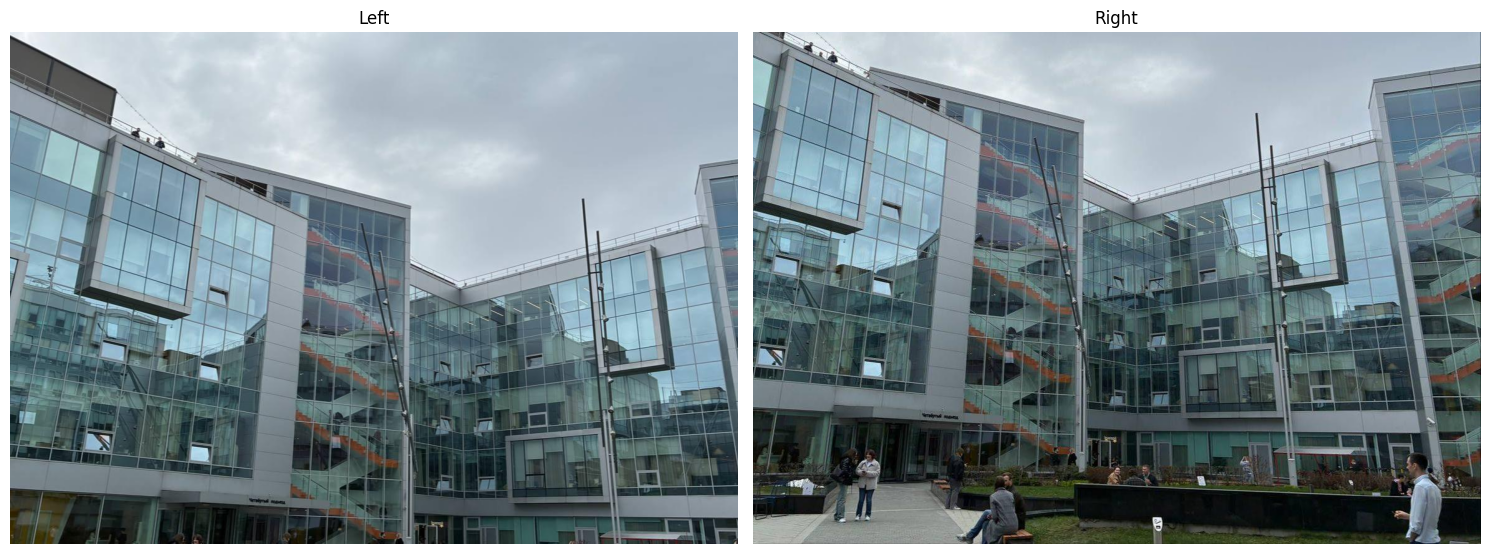

In [ ]:
# do not change the code in the block below
# __________start of block__________
image1, image2 = image_dict['example2']
imshow( [image1, image2], ['Left', 'Right'])
# __________end of block__________

## Шаг 1: Создание панорамы вручную
Подберите сдвиг по координатам X и Y (`tx` и `ty` соответственно) для второго изобаражения относительно первого для задания оптимальной трансляции (смещения) для совмещения изображений вручную. Изображения имеют размеры, приведенные ниже:

In [ ]:
print(f"first image shape: {image1.shape}, second image shape: {image2.shape}")

first image shape: (822, 1169, 3), second image shape: (822, 1167, 3)


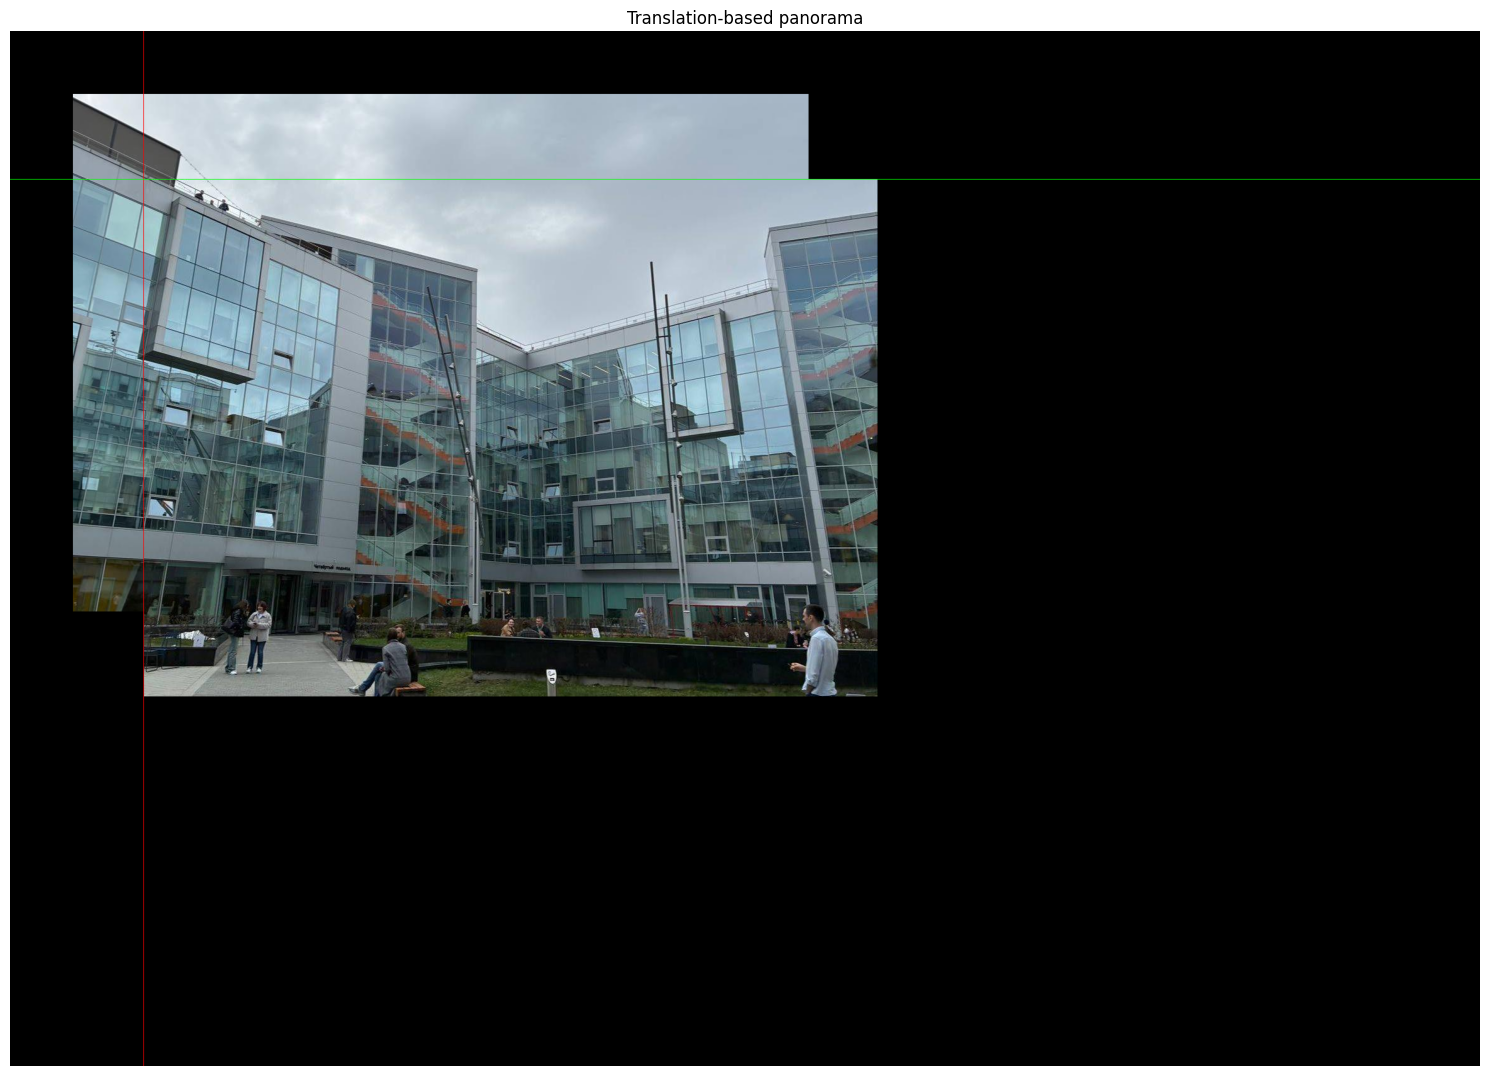

In [ ]:
X_SHIFT = 100
Y_SHIFT = 100 # so you can have negative tx and ty
tx = 112 # YOUR CODE HERE
ty = 135 # YOUR CODE HERE

assert tx + X_SHIFT >= 0
assert ty + Y_SHIFT >= 0

size = (image1.shape[0] + image2.shape[0], image1.shape[1] + image2.shape[1], 3)
image_trans = np.uint8(np.zeros(size))

# put image 1 on resulting image
image_trans[Y_SHIFT:Y_SHIFT+image1.shape[0], X_SHIFT:X_SHIFT+image1.shape[1], :] = image1

# put image 2 on resulting image
image_trans[Y_SHIFT+ty:Y_SHIFT+ty+image2.shape[0], X_SHIFT+tx:X_SHIFT+tx+image2.shape[1], :] = image2

# #add vertical line where two images are joined, use red color
image_trans[:, X_SHIFT+tx, :] = [255, 0, 0]
image_trans[Y_SHIFT+ty, :, :] = [0, 255, 0]

imshow( [image_trans], ['Translation-based panorama'])

In [ ]:
# do not change the code in the block below
# __________start of block__________
with open('manual_panorama.json', 'w') as iofile:
    json.dump([tx, ty], iofile)
# __________end of block__________

Вы можете сдать файл `manual_panorama.json` в задачу **Manual panorama** в соревновании.

## Шаг 2: Обнаружение ключевых точек

Используйте  **SIFT** из OpenCV (`cv2.SIFT_create`) для обнаружения ключевых точек и вычисления их дескрипторов на обоих изображениях.  
Для этого реализуйте функцию `extract_key_points`:

In [ ]:
def extract_key_points(img1, img2):
    # YOUR CODE HERE
    sift=cv2.SIFT_create()

    kpts1, desc1 = sift.detectAndCompute(img1, None)
    kpts2, desc2 = sift.detectAndCompute(img2, None)
    return kpts1, desc1, kpts2, desc2

kp1, des1, kp2, des2 = extract_key_points(image1, image2)


print("Coordinates of the first keypoint of image1: ", kp1[0].pt)
print("Descriptor of the first keypoint of image1:\n", des1[0])

Coordinates of the first keypoint of image1:  (3.0671353340148926, 807.9583129882812)
Descriptor of the first keypoint of image1:
 [ 11.  23.   7.   0.   0.   2.   1.  15.  17.  20.  21.   2.   0.  12.
  47.  59.   0.   8.  44.   4.   0.  33. 124.  11.   1.   7.  23.   6.
   4.  31.  39.   2.  52.   4.   0.   0.   1.   5.   2.  32. 137.  27.
   5.   6.   3.  22.  88. 137.  19.   8.  18.  63.  34. 122. 137.  41.
   0.   1.  13.  38.  93. 120.  67.   1.  43.  15.   2.   2.   3.   2.
   1.   2. 137. 137.  68.  32.   2.   2.   3.  14.  15.  39. 137. 137.
  22.  12.   5.   4.   0.   0.  89. 116.  42.   6.   0.   0.   2.   1.
   0.   0.   0.   0.   0.   0.   6.  15.  10.   4.   0.   0.   0.   0.
   0.   3.  22.  30.   0.   0.   0.   0.   0.   0.  14.  12.   0.   0.
   0.   0.]


In [ ]:
# do not change the code in the block below
# __________start of block__________
with open('keypoints_sift.json', 'r') as f:
    loaded_data = json.load(f)

for kp, loaded_kp in zip(kp1[:10], loaded_data['keypoints1']):
    assert np.allclose(kp.pt, loaded_kp, atol=1e-5), f"keypoint {kp.pt} and {loaded_kp} are not close"
# __________end of block__________

## Шаг 3: Сопоставление ключевых точек  
Далее необходимо сопоставить признаки между изображениями. Существует множество стратегий сопоставления, давайте используем самый простой подход, реализованный в [BFMatcher](https://opencv24-python-tutorials.readthedocs.io/en/stable/py_tutorials/py_feature2d/py_matcher/py_matcher.html) (от Brute Force).

Оценить качество сопоставления ключевых точек можно на основе аттрибута `distance`. Полезно отсортировать соответствия по возрастанию расстояния, чтобы первые элементы списка были наиболее релевантными.

In [ ]:

# do not change the code in the block below
# __________start of block__________
def match_key_points_cv(des1, des2):
    bf =  cv2.BFMatcher(crossCheck=True)
    matches = bf.match(des1, des2)

    sorted_matches = sorted(matches, key = lambda x:x.distance)
    return sorted_matches

def showMatches(img1, kp1, img2, kp2, matches, name):
    img = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    imshow([img],[name])
# __________end of block__________

In [ ]:
matches_cv = match_key_points_cv(des1, des2)

print(len(matches_cv))
showMatches(image1,kp1,image2,kp2,matches_cv,"all matches")
showMatches(image1,kp1,image2,kp2,matches_cv[:50],"best 50 matches")

Output hidden; open in https://colab.research.google.com to view.

Ваша задача: реализовать аналог `BFMatcher`, используя чистый `numpy`. Он основан на подсчете разницы между дескрипторами изображений и вычисляется следующим образом:

1. Подсчет матрицы попарных расстояний между дескрипторами обоих изображений.
2. Для каждого дескриптора изображения 1 находится наиболее похожий (ближайший) дескриптор изображения 2.
2. Для каждого дескриптора изображения 2 находится наиболее похожий (ближайший) дескриптор изображения 1.
4. Те пары дескрипторов, которые совпали (т.е. дескрипторы ближайшие друг для друга) считаются парами.

Шаблоны кода написаны ниже.

In [ ]:

# do not change the code in the block below
# __________start of block__________
class DummyMatch:
    def __init__(self, queryIdx, trainIdx, distance):
        self.queryIdx = queryIdx  # index in des1
        self.trainIdx = trainIdx  # index in des2
        self.distance = distance
# __________end of block__________


def match_key_points_numpy(des1: np.ndarray, des2: np.ndarray) -> list:
  onewaymatches1=np.zeros((len(des1)))
  onewaymatches2=np.zeros((len(des2)))
  distancesfrom1=np.zeros((len(des1)))
  for i in range(len(des1)):
      dif=des2-des1[i]
      distance=np.linalg.norm(dif,axis=1) #Расстояние между одним элементом 1ого дескриптора и каждым элементом 2ого
      onewaymatches1[i]=np.argmin(distance)
      distancesfrom1[i]=distance[int(onewaymatches1[i])]

  for i in range(len(des2)):
      dif=des1-des2[i]
      distance=np.linalg.norm(dif,axis=1) #Расстояние между одним элементом 2ого дескриптора и каждым элементом 1ого
      onewaymatches2[i]=np.argmin(distance)

  matches = []

  for i in range(len(onewaymatches1)):
    closest=onewaymatches1[i]
    if int(onewaymatches2[int(closest)])==i:
      matched=DummyMatch(int(i), int(closest), distancesfrom1[i])
      matches.append(matched)

  matches=sorted(matches, key=lambda x: x.distance)

  return matches


In [ ]:
cv_matches = match_key_points_cv(des1, des2)



for idx, m_cv,  in enumerate(cv_matches):
    print(m_cv.queryIdx)
    print(m_cv.trainIdx)
    print(m_cv.distance)
    break

3354
3642
7.280109882354736


Проверка:

In [ ]:

# do not change the code in the block below
# __________start of block__________
def test_numpy_bf_matcher_equivalence(des1, des2):
    # OpenCV BFMatcher
    print(des1.shape)
    cv_matches = match_key_points_cv(des1, des2)
    # Our matcher
    np_matches = match_key_points_numpy(des1, des2)

    # Compare match indices and distances
    assert len(cv_matches) == len(np_matches), f"Match count mismatch: {len(cv_matches)} vs {len(np_matches)}"

    for idx, (m_cv, m_np) in enumerate(zip(cv_matches, np_matches)):
        #print(m_cv.queryIdx - m_np.queryIdx)
        #print( m_cv.trainIdx - m_np.trainIdx)
        assert m_cv.queryIdx == m_np.queryIdx
        assert m_cv.trainIdx == m_np.trainIdx
        assert abs(m_cv.distance - m_np.distance) < 1e-4, f"Distance mismatch on {idx}th match: {m_cv.distance:.4f} vs {m_np.distance:.4f}"

    print("Your numpy implementation matches OpenCV BFMatcher output!")

test_numpy_bf_matcher_equivalence(des1, des2)
# __________end of block__________

(3764, 128)
Your numpy implementation matches OpenCV BFMatcher output!


In [ ]:
for idx, (m_cv, m_np) in enumerate(zip(cv_matches, np_matches)):
        print(m_cv.queryIdx - m_np.queryIdx)
        print( m_cv.trainIdx - m_np.trainIdx)

NameError: name 'np_matches' is not defined

Сдайте функцию `match_key_points_numpy` в задачу **BFMatcher** в соревновании.

## Шаг 4 (опциональный): Оценка матрицы гомографии с использованием DLT и RANSAC

Функция cv2.findHomography оценивает гомографию, которая преобразует исходные точки в целевые. При использовании метода RANSAC она устойчива к выбросам. Ниже доступна реализация функции с использованием RANSAC, а также с использованием более простого метода DLT.

Ваша опциональная задача: реализовать DLT на чистом `numpy`.

In [ ]:
# do not change the code in the block below
# __________start of block__________
def findHomography_dlt_opencv(matches, keypoint1, keypoint2, mode='DLT'):

    src_pts = np.float32([keypoint1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    dst_pts = np.float32([keypoint2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)

    if mode == 'DLT':
        mode = 0
    elif mode == 'RANSAC':
        mode = cv2.RANSAC
    H, mask = cv2.findHomography(src_pts, dst_pts, mode)
    mask = mask.ravel().tolist()

    inliers = []
    for i in range(len(mask)):
      if mask[i] == 1:
        inliers.append(matches[i])

    return H, inliers


H_for_panorama, inliers = findHomography_dlt_opencv(matches_cv, kp1, kp2, 'RANSAC')
showMatches(image1,kp1,image2,kp2,inliers,"inliers only, RANSAC")


H, inliers = findHomography_dlt_opencv(matches_cv, kp1, kp2, 'DLT')
showMatches(image1,kp1,image2,kp2,inliers,"DLT, all matches")

H, inliers = findHomography_dlt_opencv(matches_cv[:50], kp1, kp2, 'DLT')
showMatches(image1,kp1,image2,kp2,inliers,"DLT, top 50 matches")

# __________end of block__________

Output hidden; open in https://colab.research.google.com to view.

Ручная реализация DLT нетривиальна и опциональна. Пример с развернутым описанием и разбором можно найти, например, [здесь](https://medium.com/@insight-in-plain-sight/estimating-the-homography-matrix-with-the-direct-linear-transform-dlt-ec6bbb82ee2b).
Т.к. тонкости реализации могут варьироваться (например, нормировка), оценка похожести матрицы `H`, полученной с помощью вашей реализации и реализации `opencv` достаточно грубая.
Рекомендуем опираться также на визуальную проверку сопоставления изображений ниже.

In [ ]:
def dlt_homography_normalized(pts1: np.ndarray, pts2: np.ndarray) -> np.ndarray:
    """
    Computes homography matrix using normalized Direct Linear Transform (DLT).

    Args:
        pts1 (np.ndarray): Source points (N, 2)
        pts2 (np.ndarray): Destination points (N, 2)

    Returns:
        np.ndarray: Homography matrix (3x3)
    """
    # YOUR CODE HERE
    H = None

    return H


def findHomography_dlt_numpy(matches, keypoint1, keypoint2):
    src_pts = np.float32([keypoint1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    dst_pts = np.float32([keypoint2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)
    return dlt_homography_normalized(src_pts, dst_pts), None




Т.к. DLT неустойчив к выбросам (и вообще достаточно прост), будем использовать `NUM_BEST_MATCHES` лучших совпадений

In [ ]:
# do not change the code in the block below
# __________start of block__________
NUM_BEST_MATCHES = 50

kp1, des1, kp2, des2 = extract_key_points(*image_dict['example2'])
matches_cv = match_key_points_cv(des1, des2)

H_numpy, _ = findHomography_dlt_numpy(matches_cv[:NUM_BEST_MATCHES], kp1, kp2)
H, _ = findHomography_dlt_opencv(matches_cv[:NUM_BEST_MATCHES], kp1, kp2, mode='DLT')
assert np.allclose(H_numpy, H, atol=2e-1), f"Homography matrices are too different!\nH_numpy:\n{H_numpy}\nH from opencv:\n{H}"
# __________end of block__________

## Шаг 5. Построение панорамы
Используя матрицу гомографии `H` можно совместить две фотографии. Функция реализована для вас. Сравните с результатом, полученным вручную на шаге 1.

In [ ]:
def panorama(img1, img2, H, size):
    img = np.uint8(np.zeros(size))
    img = cv2.warpPerspective(src=img1, dst=img, M=np.eye(3), dsize=(size[1], size[0]))
    img = cv2.warpPerspective(src=img2, dst=img, M=H, dsize=(size[1], size[0]), flags=cv2.WARP_INVERSE_MAP, borderMode=cv2.BORDER_TRANSPARENT)

    return img

size = (1280, 960*2, 3)
print(image1.shape)
#imshow([panorama(image1, image2, H_for_panorama, size)],["Panorama"])

(822, 1169, 3)


## Шаг 6: Функция для построения панорам
Осталось лишь собрать воедино ваши наработки (кроме ручного DLT) и получить функцию, которая на входе имеет два изображения, а на выходе возвращает совмещенное изображение и матрицу `H`.
Благодаря использованию SIFT угол съемки может варьироваться.

Обращаем ваше внимание, даже при правильной реализации на одном из примеров панорама не будет строиться корректно (`example_5`), это нормально.

**Примечание: т.к. вариантов построения данной функции много, для успешного прохождения тестов в контесте используйте следующую последовательность:**
1. Обнаружение ключевых точек с помощью фунции `extract_key_points` с SIFT под капотом (она уже реализована выше).
2. Для сопоставления ключевых точек используйте функцию `match_key_points_cv` (она также реализована).
3. Для определения матрицы гомографии используйте `findHomography_dlt_opencv` с методом `RANSAC` (также реализована).

In [ ]:
def panorama_pipeline(img1, img2, size):

    # YOUR CODE HERE
    size=(size[1],size[0])
    keypoint1,des1,keypoint2,des2=extract_key_points(img1, img2)
    matches=match_key_points_cv(des1, des2)
    H, inliners = findHomography_dlt_opencv(matches[:73], keypoint1, keypoint2, mode='RANSAC')
    #res=cv2.warpPerspective(img1, H, size)
    res=0
    return res, H


In [158]:
img1=io.imread('11.jpg')
img2=io.imread('12.jpg')
img2.shape

(1920, 2560, 3)

In [ ]:
def panorama(img1, img2, H, size):
    img = np.uint8(np.zeros(size))
    img = cv2.warpPerspective(src=img1, dst=img, M=np.eye(3), dsize=(size[1], size[0]))
    img = cv2.warpPerspective(src=img2, dst=img, M=H, dsize=(size[1], size[0]), flags=cv2.WARP_INVERSE_MAP, borderMode=cv2.BORDER_TRANSPARENT)

    return img

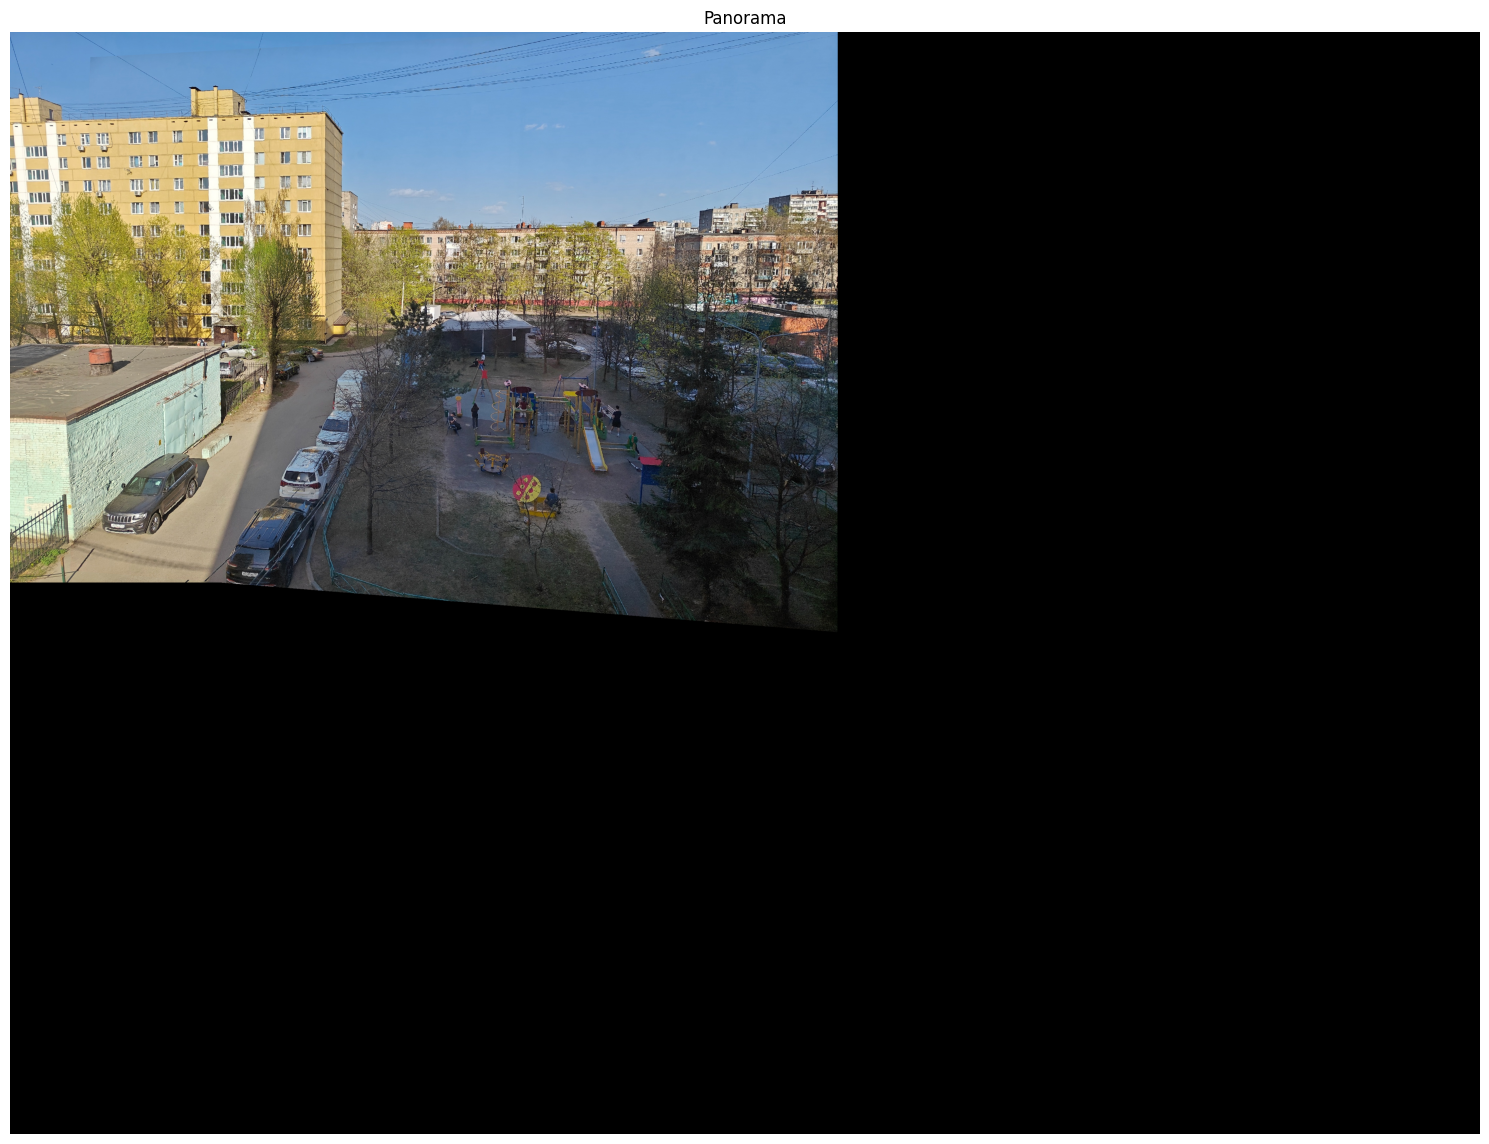

In [159]:
# do not change the code in the block below
# __________start of block__________
size = (1920*2, 2560*2, 3)
h_dict = {}

final_image, H = panorama_pipeline(img1, img2, size)

imshow([panorama(img1, img2, H, size)],["Panorama"])

# __________end of block__________

Сдайте `h_submission_dict.json` в задачу **Homography mapping**.

## Шаг 7: Ваш telegram login
Запишите ваш telegram login в формате ссылки https://t.me/username в строку ниже. Он будет нужен для участия в тестах.

In [ ]:
your_telegram_login = 'https://t.me/serega121234'

# do not change the code in the block below
# __________start of block__________
assert your_telegram_login[:13] == 'https://t.me/'
assert '@' not in your_telegram_login

with open('telegram_login.json', 'w') as iofile:
    json.dump([your_telegram_login], iofile)
# __________end of block__________

## Сдача задания
Для сдачи задания вам необходимо:
 * Сдать файл `manual_panorama.json` в задачу **Manual panorama** в соревновании.
 * Сдать функцию `match_key_points_numpy` в задачу **BFMatching** в соревновании.
 * Сдать `h_submission_dict.json` в задачу **Homography mapping**.
 * Сдать `telegram_login.json` в задачу **telegram_login** для участия в тестах.

Не забудьте, что при сдаче кода все импортируемые библиотеки также должны вставляться вместе с вашим кодом. Вы не должны использовать что-либо, кроме `numpy` при написании решения.

На этом задание завершено. Поздравляем!